In [2]:
%load_ext autoreload
%autoreload 2
from torcher.algorithms.skill_extractors import (
    FuzzyMatchSkillExtractor,
    ExactMatchSkillExtractor,
    SocScopedExactMatchSkillExtractor,
    SectionExtractSkillExtractor,
    SkillEndingPatternExtractor,
    AbilityEndingPatternExtractor
)

from torcher.dataset.ontology.onet import Onet
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *
import seaborn as sns
from functools import partial

db_dir = "db"
onet = Onet()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Below we consider the job administive services manager (Onet id 11-3012.00), and extract skills from USAJobs

We have more data then client's database & Onet's website. Since they only show skills that have score >= 3.

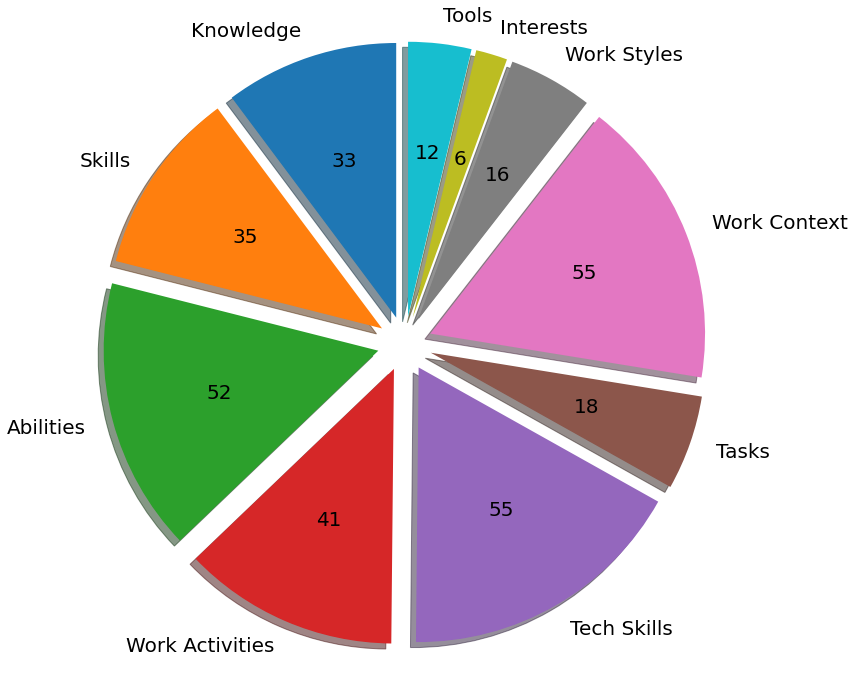

In [4]:
def plot_pie(onet, id):
    pie = []
    labels = []
    for KSAT in ["Knowledge", "Skills", "Abilities", "Work Activities",
                 "Tech Skills", 'Tasks', "Work Context", "Work Styles",
                 "Interests", "Tools"]:
        manager = onet.filter_by(
            lambda edge: edge.occupation.identifier==id\
                        and KSAT in edge.competency.categories
        )
        labels.append(KSAT)
        pie.append(len(manager.competencies))
    total = sum(pie)
    _, ax = plt.subplots(figsize=(12,12))
    plt.pie(pie, explode=[0.1]*len(pie),
            autopct=lambda p: '{:.0f}'.format(p * total / 100),
            labels=labels,
            shadow=True, startangle=90)
    ax.axis("equal")
    
import matplotlib as mpl
mpl.rcParams['font.size'] = 20.0
plot_pie(onet, "11-3012.00")

original score from Onet (some based on survey): $s \in [1,5]$, where 1 is least important and 5 is the most important.

We can eventually map to $s' = \dfrac{s-1}{5-1} \cdot 100$ such that $s'$ would be from 0 to 100. 

From the extracted skills we only have the counts of skills. Similar to the traditional approach in NLP pertaining to co-occurance matrix and estimate prob based on MLE

Let $S$ all skills from Onet

1. probability:

   $P(\text{skill }s \in S) = \dfrac{count(s, corpus)}{\sum_{s \in S}count(s, corpus))}$

2. conditional probability:

   $P(\text{skill }s \in S \mid \text{job } j) = \dfrac{count(s, corpus_{j})}{\sum_{s \in S}count(s, corpus_j))}$

We separate the job postings based on the jobs so we are using the 2nd one as an estimation

applying smoothing so that skills with count = 0 also have postive probablity

1. add-$\alpha$  [Chen and Goodman, 1999, Goodman,
2001, Lidstone, 1920]

2. back-off or JM interpolated [Chen and Goodman, 1999, Jelinek and Mercer, 1980]: works for n-gram not in here

3. Laplace: same

4. PMI [Dagan
et al., 1994, Turney, 2001, Turney and Pantel, 2010].
: define for bi-gram not suitable for this task. 

5. downweight skills s for job j
    
    $w_{sj} = count(s, corpus_j) \cdot \ln (\dfrac{|S|}{|corpus_j|})$
    
    tried, but not so effective

Future changes: 

Linkedin profile: maybe more suitable for skills since 1. they list explictly the skills they hold and these are more related to the industry they are in. 2. Less noisy

In [6]:
def tech_skills_or_having_scores(edge):
    return any(tech in edge.competency.categories for tech in ["Tech Skills" , 'Tools']) \
                or any(c.startswith("IM-") for c in edge.competency.categories)
manager = onet.filter_by(lambda e: e.occupation.identifier=='11-3012.00')

manager = manager.filter_by(tech_skills_or_having_scores)


In [3]:
manager = onet.filter_by(lambda e: e.occupation.identifier=='11-3012.00')
# only those having scores or tools
def tech_skills_or_having_scores(edge):
    return any(tech in edge.competency.categories for tech in ["Tech Skills" , 'Tools']) \
                or any(c.startswith("IM-") for c in edge.competency.categories)
manager = manager.filter_by(tech_skills_or_having_scores)
manager.name = "administive services managerer"
manager.competency_framework.name = "manager"
manager.competency_framework.description = "manager"
manager.print_summary_stats()

class USAJobsCollection:
    def __init__(self, postings: dict):
        """{'idx": {job info}"""
        self.postings = postings
    def __iter__(self):
        for id, job_info in self.postings.items():
            d = {
                "description": job_info["QualificationSummary"],
                "id": id,
                "@type": "JobPosting",
                "title": job_info["PositionTitle"]
                }
            yield d
    def __len__(self):
        return len(self.postings)

with open(os.path.join(db_dir,"USAJobs-Administrative_Services_Managers&Business_Manager.pkl"), "rb") as f:
    usaJobs = pickle.load(f)

def extract_skills_from(sample, skill_extractors):
    data = defaultdict(dict)
    for s in sample:
       for i in skill_extractors.candidate_skills(s):
           d = data[i.matched_skill_identifier]
           for cat in i.skill_cat:
               if cat.startswith("IM-"):
                   d["score"] = float(cat[3:])
               else:
                   d["cat"] = cat
           d["count"] = d.get("count", 0) + 1
           d["skills"] = i.skill_name
    return data

def merge_extracted_skills(*datas):
    if not datas:
        return {}
    ret = datas[0]
    for data in datas[1:]:
        for id, d in data.items():
            if id not in ret:
                ret[id] = d
            else:
                ret[id]['count'] += d['count']
    return ret

skill_extractors = ExactMatchSkillExtractor(manager.competency_framework)
data = merge_extracted_skills(
    *[
        extract_skills_from(sample = USAJobsCollection(job),
                            skill_extractors=skill_extractors)
        for job in usaJobs.values()
    ]
)

print()
print(f"unique skills {len(data)} in total {sum(v['count'] for v in data.values())} skills")

Ontology summary statistics for administive services managerer
Num competencies: 244
Num occupations: 1
Num competency-occupation edges: 244
Median occupations per competency: 1.0
Median competencies per occupation: 244
Mean occupations per competency: 1
Mean competencies per occupation: 244

unique skills 70 in total 2251 skills


In [4]:
def extract_competency(competency):
    # having IM scores
    if any("-" in cat for cat in competency.categories):
        for cat in competency.categories:
            if "-" in cat:
                score = float(cat.split("-")[1])
            else:
                category = cat
    # tech skills
    else:
        # baseline scores
        score = 2
        for cat in competency.categories:
            if cat == "HOT":
                score = 4
            elif cat in ["Tools", "Tech Skills"]:
                category = cat
            
    return competency.identifier, competency.name, category, score, 0

df = pd.DataFrame(
    [extract_competency(comp) for comp in manager.competencies],
    columns=["id", "name", "cat", "score", "count"]
)
df = df.set_index("id")
for id, skill in data.items():
    df.loc[id, "count"] = skill["count"]

df["score"].min(), df['score'].max()

(1.0, 4.97)

Onet only have scores for these 5 categories, plus Onet's hot/not hot tech skills

Below we can see most abilities, work activities can't be extracted from the job posting data

yellow and blue are in different scale

Text(0.5, 1.0, 'compare db & extracted skills')

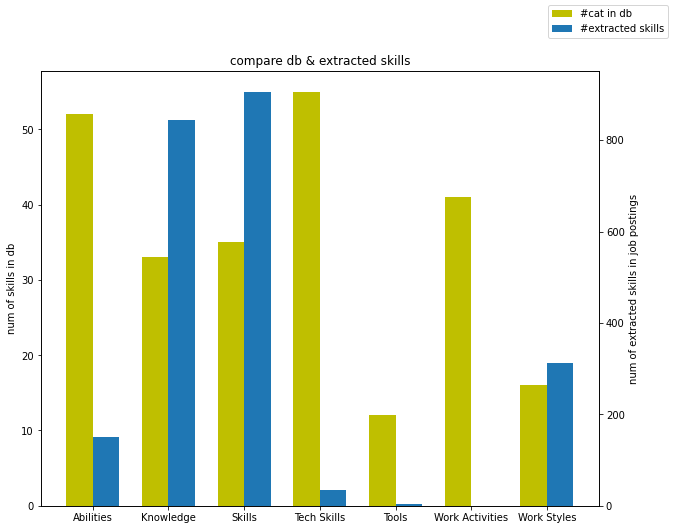

In [5]:
fig,ax=plt.subplots(
    figsize=(10,8)
)
group = df.groupby("cat")
cats = list(group.groups.keys())
x = np.arange(len(cats))
width = 0.35
ax.bar(x - width/2, group["name"].count(), width, label="#cat in db", color="y")
ax.set_ylabel("num of skills in db")
ax.set_xticks(x)
ax.set_xticklabels(cats)
newax = ax.twinx()
newax.bar(x + width/2, group["count"].sum(), width, label="#extracted skills")
newax.set_ylabel("num of extracted skills in job postings")
leg = fig.legend(loc="upper right")
plt.title("compare db & extracted skills")

Most often show up tech skills are microsoft office, the only two tools show up is about computer

Not too much tech skills show up in the job postings it seems

In [6]:
df.query("cat =='Tech Skills' & count == 13")

,name,cat,score,count
id,,,,
43231513-Microsoft Office,Microsoft Office,Tech Skills,4.0,13


In [7]:
df.query("cat =='Tools' & count != 0")

,name,cat,score,count
id,,,,
43211503-Laptop computers,Laptop computers,Tools,2.0,1
43211508-Personal computers,Personal computers,Tools,2.0,3


In [8]:
df.sort_values(by="count").tail(5)
total_counts = df["count"].sum()
df["prob"] = df.apply(lambda row: row["count"]/total_counts, axis=1)
print(f"{len(df[df['prob'] == 0])} skills are prob 0")

174 skills are prob 0


In [9]:
# total number of skills of manager
num_S = len(manager._competency_occupation_edges)

alpha = 1
df["smoothed"] = df.apply(lambda row: (row["count"] + alpha) / (total_counts + alpha * num_S), axis=1)
df["max_divide"] = df.apply(lambda row: row["count"] / df["count"].max(), axis=1)
df["max_divide_smoothed"] = df.apply(lambda row: (row["count"] + alpha) / (df["count"].max() + alpha * num_S), axis=1)
df["min_divide_smoothed"] = df.apply(lambda row: (row["count"] + alpha) / (df["count"].min() + alpha * num_S), axis=1)

Prob is aligned with the number of times skill show up in the job postings

<AxesSubplot:xlabel='smoothed', ylabel='count'>

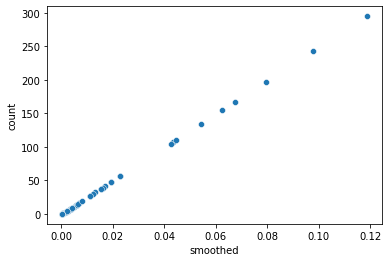

In [10]:
sns.scatterplot(x = "smoothed", y = "count", data=df)

<AxesSubplot:xlabel='count', ylabel='score'>

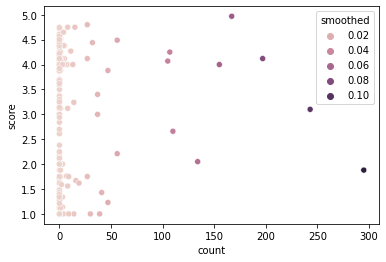

In [11]:
sns.scatterplot(x="count", y = "score", data=df, hue="smoothed")

In [12]:
df[(df["score"] >= 4) & (df["count"] == 0)]

,name,cat,score,count,prob,smoothed,max_divide,max_divide_smoothed,min_divide_smoothed
id,,,,,,,,,
43231505-ADP Workforce Now,ADP Workforce Now,Tech Skills,4.00,0,0.0,0.000401,0.0,0.001855,0.004098
4.A.4.a.2,"Communicating with Supervisors, Peers, or Subo...",Work Activities,4.73,0,0.0,0.000401,0.0,0.001855,0.004098
4.A.2.a.3,Evaluating Information to Determine Compliance...,Work Activities,4.22,0,0.0,0.000401,0.0,0.001855,0.004098
43233501-IBM Notes,IBM Notes,Tech Skills,4.00,0,0.0,0.000401,0.0,0.001855,0.004098
43231602-Oracle PeopleSoft,Oracle PeopleSoft,Tech Skills,4.00,0,0.0,0.000401,0.0,0.001855,0.004098
...,...,...,...,...,...,...,...,...,...
2.B.2.i,Complex Problem Solving,Skills,4.38,0,0.0,0.000401,0.0,0.001855,0.004098
1.A.4.b.5,Speech Clarity,Abilities,4.12,0,0.0,0.000401,0.0,0.001855,0.004098
4.A.4.b.4,"Guiding, Directing, and Motivating Subordinates",Work Activities,4.57,0,0.0,0.000401,0.0,0.001855,0.004098


In [13]:
# put those in a pipeline

def skills_from_USAJobs(ontology, usaJobs: dict, skill_extractors, alpha=1):
    data = merge_extracted_skills(
        *[
            extract_skills_from(sample = USAJobsCollection(job),
                                skill_extractors=skill_extractors)
            for job in usaJobs.values()
        ]
    )
    print(f"unique skills {len(data)} in total {sum(v['count'] for v in data.values())} skills")
    df = pd.DataFrame(
        [extract_competency(comp) for comp in ontology.competencies],
        columns=["id", "name", "cat", "score", "count"]
    )
    df = df.set_index("id")
    for id, skill in data.items():
        df.loc[id, "count"] = skill["count"]
        
    total_counts = df["count"].sum()
    df["prob"] = df.apply(lambda row: row["count"]/total_counts, axis=1)
    
    num_S = len(ontology._competency_occupation_edges)
    df["smoothed"] = df.apply(
        lambda row: (row["count"] + alpha) / (total_counts + alpha * num_S), axis=1)
    df["max_divide"] = df.apply(
        lambda row: row["count"] / df["count"].max(), axis=1)
    df["max_divide_smoothed"] = df.apply(
        lambda row: (row["count"] + alpha) / (df["count"].max() + alpha * num_S), axis=1)
    df["min_divide_smoothed"] = df.apply(
        lambda row: (row["count"] + alpha) / (df["count"].min() + alpha * num_S), axis=1)
    df.sort_values(by="count").tail(5)
    return df

without work activities and ability and tech skills and tools since they seldom shows up

In [62]:
manager = onet.filter_by(lambda e: e.occupation.identifier=='11-3012.00')
# only those having scores
manager = manager.filter_by(lambda e: any(c.startswith("IM-") for c in e.competency.categories))
# without work style and work activities
manager = manager.filter_by(lambda e: (
        "Work Activities" not in e.competency.categories and
        "Abilities" not in e.competency.categories
))
manager.name="manager"
manager.competency_framework.name = "manager"
manager.competency_framework.description = "manager"
manager.print_summary_stats()

with open(os.path.join(db_dir,"USAJobs-Administrative_Services_Managers&Business_Manager.pkl"), "rb") as f:
    usaJobs = pickle.load(f)
df = skills_from_USAJobs(manager, usaJobs, 
                        ExactMatchSkillExtractor(manager.competency_framework)
                        )

Ontology summary statistics for manager
Num competencies: 84
Num occupations: 1
Num competency-occupation edges: 84
Median occupations per competency: 1.0
Median competencies per occupation: 84
Mean occupations per competency: 1
Mean competencies per occupation: 84
unique skills 57 in total 2063 skills


Those skills that can't extracted from job postings are also those which aren't commonly mentioned in the job postings

In [63]:
df[(df["score"] >= 4) & (df["count"] == 0)]

,name,cat,score,count,prob,smoothed,max_divide,max_divide_smoothed,min_divide_smoothed
id,,,,,,,,,
1.C.4.c,Adaptability/Flexibility,Work Styles,4.20,0,0.0,0.000466,0.0,0.002639,0.011905
1.C.4.a,Self Control,Work Styles,4.52,0,0.0,0.000466,0.0,0.002639,0.011905
2.C.1.e,Customer and Personal Service,Knowledge,4.09,0,0.0,0.000466,0.0,0.002639,0.011905
1.C.4.b,Stress Tolerance,Work Styles,4.75,0,0.0,0.000466,0.0,0.002639,0.011905
1.C.1.a,Achievement/Effort,Work Styles,4.55,0,0.0,0.000466,0.0,0.002639,0.011905
1.C.1.b,Persistence,Work Styles,4.43,0,0.0,0.000466,0.0,0.002639,0.011905
1.C.3.b,Concern for Others,Work Styles,4.22,0,0.0,0.000466,0.0,0.002639,0.011905
2.A.1.a,Reading Comprehension,Skills,4.12,0,0.0,0.000466,0.0,0.002639,0.011905
1.C.7.b,Analytical Thinking,Work Styles,4.45,0,0.0,0.000466,0.0,0.002639,0.011905


the most frequently extracted skills are "science"

In [64]:
df[df["count"] == df["count"].max()]

,name,cat,score,count,prob,smoothed,max_divide,max_divide_smoothed,min_divide_smoothed
id,,,,,,,,,
2.A.1.f,Science,Skills,1.88,295,0.142996,0.137867,1.0,0.781003,3.52381


attempted approach: a convex combination of $s_0$ and $w_s \cdot s_0$, i.e. the weight learned by job postings

$$s_{new} = \lambda \cdot s_0 + (1-\lambda) \cdot w_s$$

in here we pick $\lambda = 0.9$

In [65]:
def calculate_new_score(row, prob="smoothed"):
    new_score = row["score"]
    min_prob, max_prob = df[prob].min(), df[prob].max()
    weight = (row[prob] - min_prob) * (1.5-0.5) / (max_prob - min_prob) + 0.5
    new_score = new_score * (0.9 + 0.1 * weight)
    return min( max(new_score, 1), 5)

df["new score"] = df.apply(calculate_new_score, axis=1)

We lower the score for those not showing up in job postings too much and higher the score for those showing up in the job positngs a lot

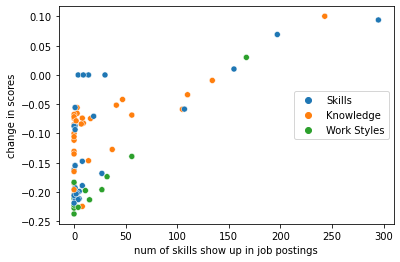

In [66]:
# plt.sub
sp=sns.scatterplot(x=df["count"], y=df["new score"]- df["score"] , hue=df["cat"])
plt.xlabel("num of skills show up in job postings")
plt.ylabel("change in scores")
plt.legend(loc="right")

For those which can be expected to extract a lot of tech skills

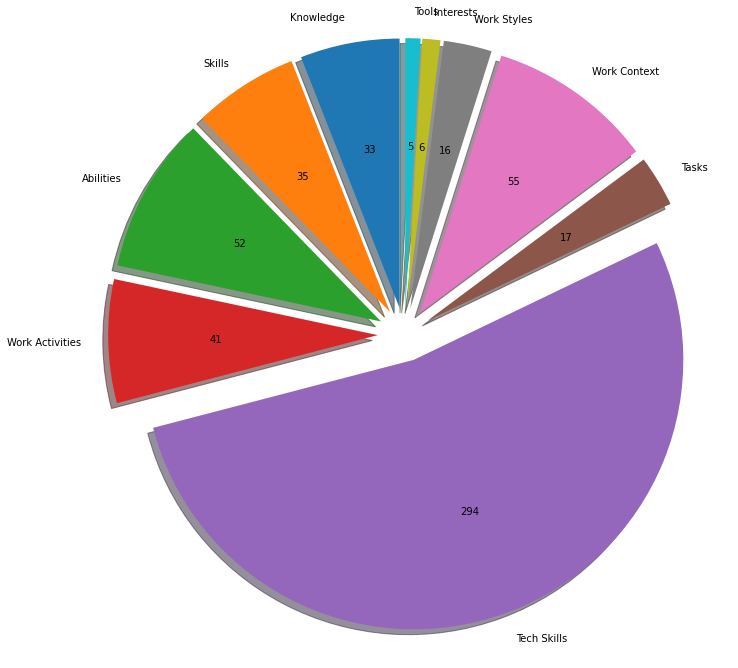

In [19]:
plot_pie(onet, "15-1251.00")

In [122]:
class DFJobPostingCollection:
    def __init__(self, df: pd.DataFrame):
        self.df = df
    def __iter__(self):
        for idx , ser in self.df.iterrows():
            d = {
                "description": ser["JobDescription"],
                # "experienceRequirements": ser["Level"],
                "id": idx,
                "@type": "JobPosting",
                "title": ser["Title"]
                }
            yield d
    def __len__(self):
        i = len(self.df)
        return i
    
def skills_from_DFJobPostings(ontology, dfJob: pd.DataFrame, skill_extractors, alpha=1):
    data = extract_skills_from(sample = DFJobPostingCollection(dfJob),
                    skill_extractors=skill_extractors)
            
    print(f"unique skills {len(data)} in total {sum(v['count'] for v in data.values())} skills")
    df = pd.DataFrame(
        [extract_competency(comp) for comp in ontology.competencies],
        columns=["id", "name", "cat", "score", "count"]
    )
    df = df.set_index("id")
    for id, skill in data.items():
        df.loc[id, "count"] = skill["count"]
        
    total_counts = df["count"].sum()
    df["prob"] = df.apply(lambda row: row["count"]/total_counts, axis=1)
    try:
        df = df.drop("43232405-Self")    
    except:
        pass
    num_S = len(ontology._competency_occupation_edges)
    df["smoothed"] = df.apply(
        lambda row: (row["count"] + alpha) / (total_counts + alpha * num_S), axis=1)
    df["max_divide"] = df.apply(
        lambda row: row["count"] / df["count"].max(), axis=1)
    df["max_divide_smoothed"] = df.apply(
        lambda row: (row["count"] + alpha) / (df["count"].max() + alpha * num_S), axis=1)
    df["min_divide_smoothed"] = df.apply(
        lambda row: (row["count"] + alpha) / (df["count"].min() + alpha * num_S), axis=1)
    df.sort_values(by="count").tail(5)
    return df

cs = onet.filter_by(lambda e: e.occupation.identifier=='15-1251.00')
cs.name = "cs"
cs = cs.filter_by(tech_skills_or_having_scores)
cs = cs.filter_by(lambda e: (
        "Work Activities" not in e.competency.categories and
        "Abilities" not in e.competency.categories
))
cs.competency_framework.name = "cs"
cs.competency_framework.description = "cs"
cs.print_summary_stats()

job_posts = pd.read_csv(os.path.join(db_dir, "data job posts.csv"))
job_posts = job_posts[job_posts["JobDescription"].notna()]

df = skills_from_DFJobPostings(cs, job_posts, 
                        ExactMatchSkillExtractor(cs.competency_framework)
                        )

Ontology summary statistics for None
Num competencies: 383
Num occupations: 1
Num competency-occupation edges: 383
Median occupations per competency: 1
Median competencies per occupation: 383
Mean occupations per competency: 1
Mean competencies per occupation: 383
unique skills 91 in total 6326 skills


Text(0.5, 1.0, 'compare db & extracted skills')

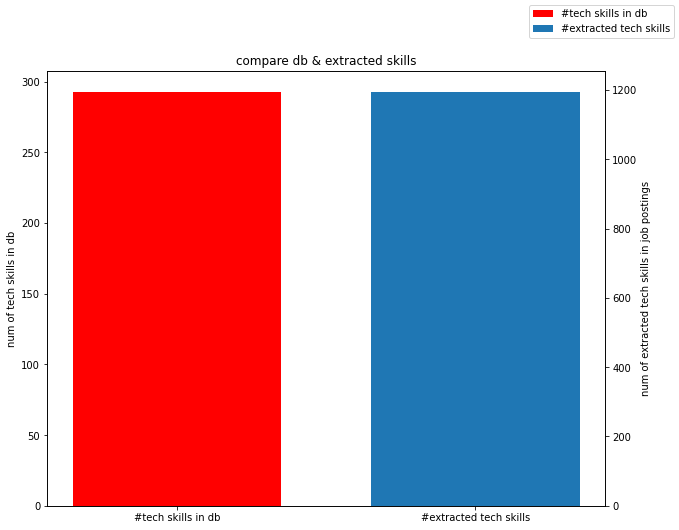

In [125]:
fig,ax=plt.subplots(
    figsize=(10,8)
)
width = 0.35
ax.bar(0, len(df.query("cat == 'Tech Skills'")),width, label="#tech skills in db", color='r')
ax.set_ylabel("num of tech skills in db")

ax.set_xticks([0,0.5])
ax.set_xticklabels(["#tech skills in db", "#extracted tech skills"])
newax = ax.twinx()
newax.bar(0.5 , df.query("cat == 'Tech Skills'")["count"].sum(), width, 
          label="#extracted tech skills")
newax.set_ylabel("num of extracted tech skills in job postings")
leg = fig.legend(loc="upper right")
plt.title("compare db & extracted skills")

Text(0.5, 1.0, 'compare db & extracted skills')

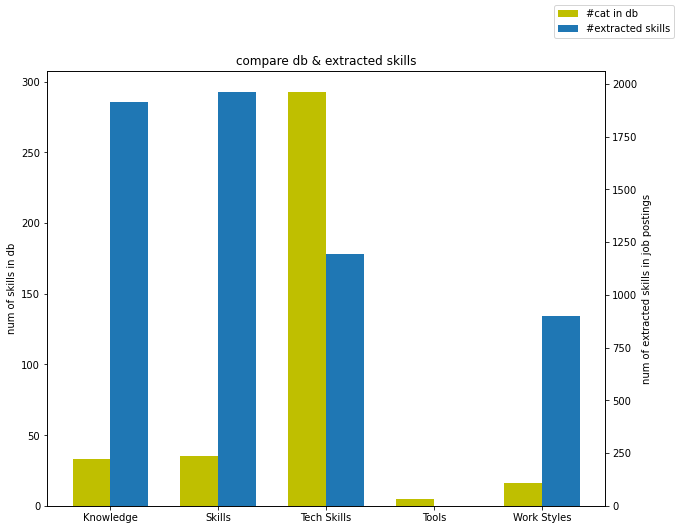

In [126]:
fig,ax=plt.subplots(
    figsize=(10,8)
)
group = df.groupby("cat")
cats = list(group.groups.keys())
x = np.arange(len(cats))
width = 0.35
ax.bar(x - width/2, group["name"].count(), width, label="#cat in db", color="y")
ax.set_ylabel("num of skills in db")
ax.set_xticks(x)
ax.set_xticklabels(cats)
newax = ax.twinx()
newax.bar(x + width/2, group["count"].sum(), width, label="#extracted skills")
newax.set_ylabel("num of extracted skills in job postings")
leg = fig.legend(loc="upper right")
plt.title("compare db & extracted skills")

Remove the head so that less biased

In [137]:
def calculate_new_score(row, prob="smoothed"):
    new_score = row["score"]
    tech_cat=["Tools", "Tech Skills"]
    tech = df["cat"].isin(tech_cat)
    cur = df[tech] if row["cat"] in tech_cat else df[~tech]
    min_prob, max_prob = cur[prob].min(), cur[prob].nlargest(10).iloc[5]
    prob = min(row[prob], max_prob)
    weight = (prob - min_prob) * (1.5-0.5) / (max_prob - min_prob) + 0.5
    new_score = new_score * (0.9 + 0.1 * weight)
    return min( max(new_score, 1), 5)

calculate_new_score = partial(calculate_new_score, prob="smoothed")
df["new score"] = df.apply(calculate_new_score, axis=1)

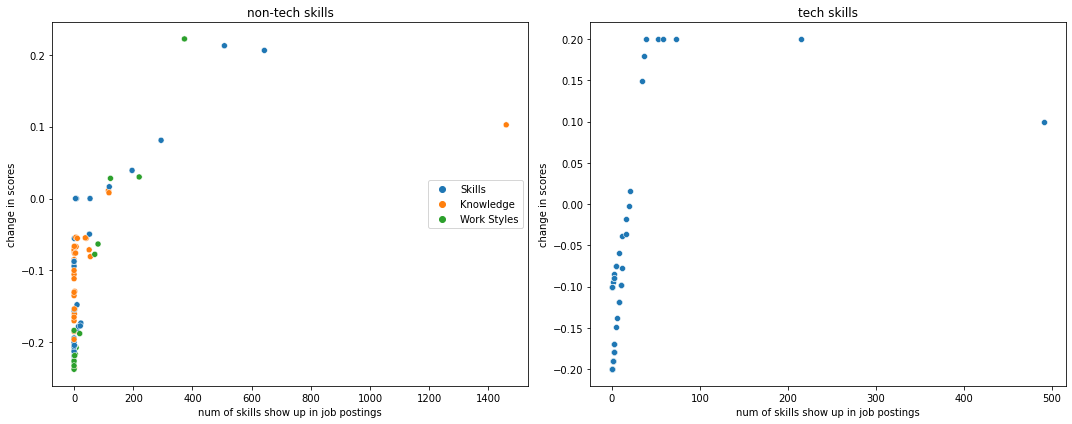

In [138]:
plt.figure(1, figsize=(15,6))
plt.subplot(121)
tech = df["cat"].isin(["Tools", "Tech Skills"])
non_tech = df[~tech]
sns.scatterplot(x=non_tech["count"], y=non_tech["new score"]- non_tech["score"] , hue=non_tech["cat"])
plt.xlabel("num of skills show up in job postings")
plt.ylabel("change in scores")
plt.legend(loc="right")
# plt.xlim((-1,100))
# plt.ylim((-1,0.75))
plt.title("non-tech skills")
plt.subplot(122)
tech = df[tech]
sns.scatterplot(x=tech["count"], y=tech["new score"]- tech["score"])
plt.xlabel("num of skills show up in job postings")
plt.ylabel("change in scores")
# plt.xlim((-1,100))
# plt.ylim((-1,0.75))
# plt.legend(loc="right")
plt.title("tech skills")
plt.tight_layout()

Common tech skills

In [129]:
tech["count"].nlargest(5)

id
43232402-C             491
43232605-SAS           215
43233004-Linux          73
43232405-R              58
43232408-JavaScript     53
Name: count, dtype: int64